3.1.6
Running burn-in for 1000 steps...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 794.06it/s]


Running production run for 5000 steps...


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 813.41it/s]



Mean posterior parameters:
m = 2.405 +0.029 -0.029
b = 1.388 +0.168 -0.168
log_sigma = -1.099 +0.230 -0.232


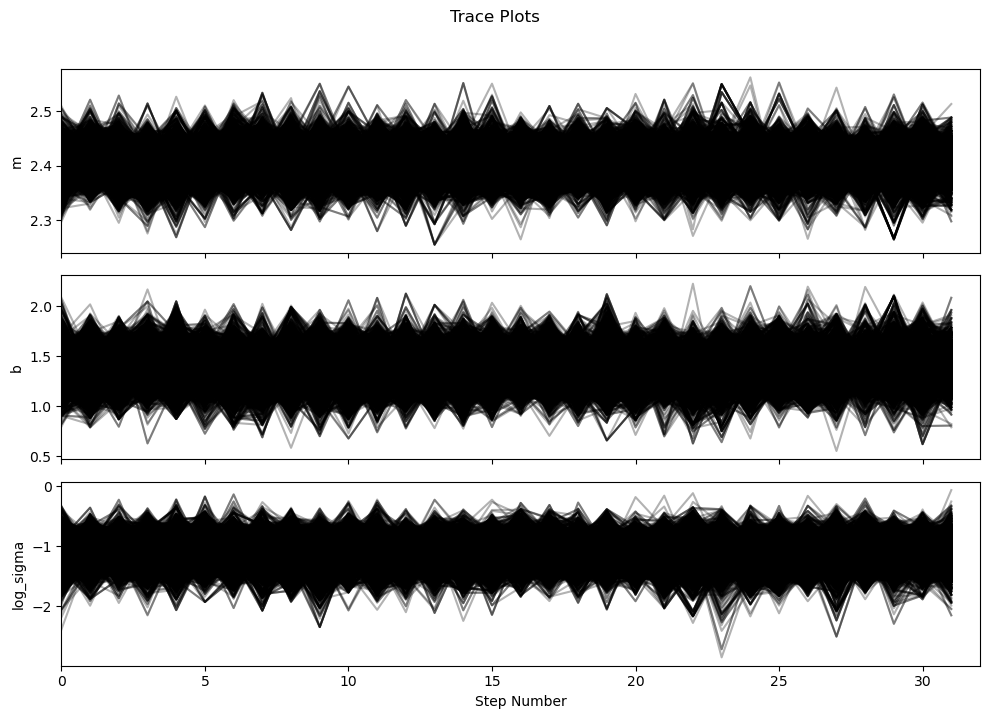

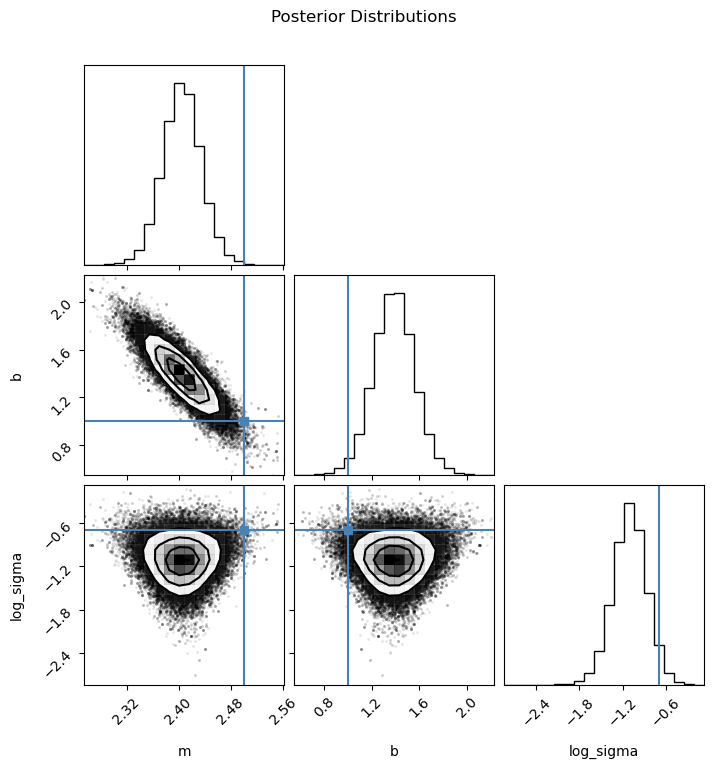

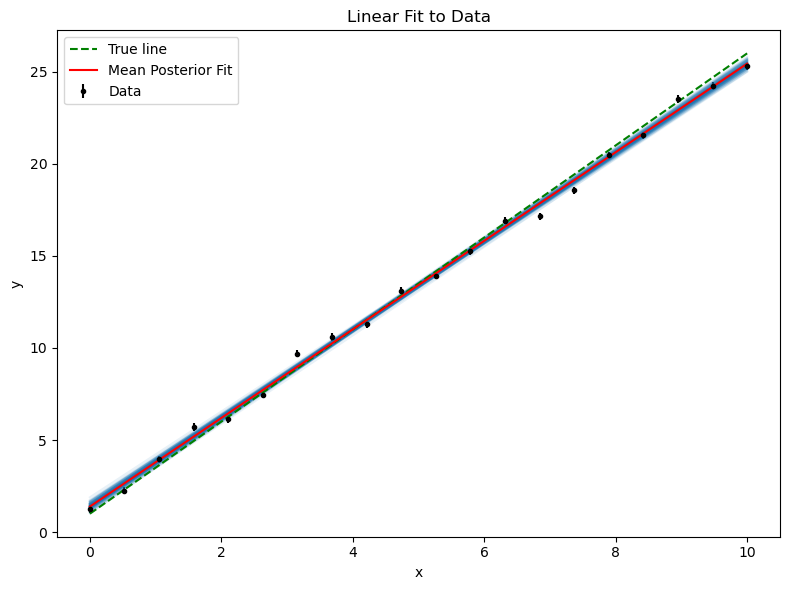

In [2]:
import numpy as np
import emcee; print(emcee.__version__)
import matplotlib.pyplot as plt
import corner

class MCMCAnalysis:
    def __init__(self, true_m, true_b, true_sigma, seed=42):
        self.true_m = true_m
        self.true_b = true_b
        self.true_sigma = true_sigma
        self.seed = seed
        self.ndim = 3
        self.nwalkers = 32
        self.n_burn = 1000
        self.n_steps = 5000
        self.labels = ["m", "b", "log_sigma"]
        self.x, self.y, self.yerr = self._generate_data()
        self.sampler = self._setup_sampler()
        self.flat_samples = None

    def _generate_data(self):
        np.random.seed(self.seed)
        x = np.linspace(0, 10, 20)
        y = self.true_m * x + self.true_b + np.random.normal(0, self.true_sigma, len(x))
        yerr = np.ones_like(y) * 0.2
        return x, y, yerr

    def _log_likelihood(self, theta, x, y, yerr):
        m, b, log_sigma = theta
        model = m * x + b
        sigma2 = np.exp(2 * log_sigma)
        return -0.5 * np.sum((y - model)**2 / (yerr**2 + sigma2) + np.log(2 * np.pi * (yerr**2 + sigma2)))

    def _log_prior(self, theta):
        m, b, log_sigma = theta
        if -5.0 < m < 5.0 and -5.0 < b < 5.0 and -3.0 < log_sigma < 1.0:
            return 0.0
        return -np.inf

    def _log_probability(self, theta, x, y, yerr):
        lp = self._log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self._log_likelihood(theta, x, y, yerr)

    def _setup_sampler(self):
        p0 = np.random.normal([self.true_m, self.true_b, np.log(self.true_sigma)], 0.1, size=(self.nwalkers, self.ndim))
        return emcee.EnsembleSampler(self.nwalkers, self.ndim, self._log_probability, args=(self.x, self.y, self.yerr))

    def run_mcmc(self):
            p0 = np.random.normal([self.true_m, self.true_b, np.log(self.true_sigma)], 0.1, size=(self.nwalkers, self.ndim))
            print(f"Running burn-in for {self.n_burn} steps...")
            state = self.sampler.run_mcmc(p0, self.n_burn, progress=True)
            self.sampler.reset()
            print(f"Running production run for {self.n_steps} steps...")
            self.sampler.run_mcmc(state, self.n_steps, progress=True)
            self.flat_samples = self.sampler.get_chain(flat=True)
    
            print("\nMean posterior parameters:")
            for i in range(self.ndim):
                mcmc = np.percentile(self.flat_samples[:, i], [16, 50, 84])
                q = np.diff(mcmc)
                print(f"{self.labels[i]} = {mcmc[1]:.3f} +{q[1]:.3f} -{q[0]:.3f}")

    def plot_trace(self):
        fig, axes = plt.subplots(self.ndim, sharex=True, figsize=(10, 7))
        for i in range(self.ndim):
            ax = axes[i]
            ax.plot(self.sampler.chain[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(self.sampler.chain))
            ax.set_ylabel(self.labels[i])
        axes[-1].set_xlabel("Step Number")
        fig.suptitle("Trace Plots", y=1.02)
        plt.tight_layout()
        return fig

    def plot_corner(self):
        fig = corner.corner(self.flat_samples, labels=self.labels, truths=[self.true_m, self.true_b, np.log(self.true_sigma)])
        fig.suptitle("Posterior Distributions", y=1.02)
        return fig

    def plot_data_fit(self, n_samples=100):
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.errorbar(self.x, self.y, yerr=self.yerr, fmt=".k", capsize=0, label="Data")
        x_plot = np.linspace(0, 10, 100)
        for i in np.random.randint(len(self.flat_samples), size=n_samples):
            sample = self.flat_samples[i]
            ax.plot(x_plot, sample[0] * x_plot + sample[1], "C0", alpha=0.1)
        m_best, b_best, _ = np.median(self.flat_samples, axis=0)
        ax.plot(x_plot, self.true_m * x_plot + self.true_b, "g--", label="True line")
        ax.plot(x_plot, m_best * x_plot + b_best, "r-", label="Mean Posterior Fit")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.legend()
        ax.set_title("Linear Fit to Data")
        fig.tight_layout()
        return fig

if __name__ == "__main__":
    analysis = MCMCAnalysis(true_m=2.5, true_b=1.0, true_sigma=0.5)
    analysis.run_mcmc()

    trace_fig = analysis.plot_trace()
    plt.show()

    corner_fig = analysis.plot_corner()
    plt.show()

    fit_fig = analysis.plot_data_fit()
    plt.show()